# Google DR Search

In [6]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import tqdm
import datetime as dt

# Import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

## Set up search terms

In [2]:
search_terms = []
for i in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sept.', 'okt.', 'nov.', 'dec.']
    for j in months:
        term = [f'"{j} {i}" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ \n']
        search_terms.append(term)
search_terms[0]

['"jan. 2012" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ \n']

In [3]:
headers={"Name" : "Simon Ullrich - summer course project" , "email": "simon.ullrich@sodas.ku.dk"}

In [20]:
# Set up virtual browser
html_list = []

for i in tqdm.tqdm(search_terms[0:1]):
    driverService = Service(r"C:\Users\jgb569\OneDrive - University of Copenhagen\Documents\Webscraping\chromedriver.exe") 
    driver = webdriver.Chrome(service = driverService)
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles on Google
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(i)
    html = driver.page_source
    html_list.append(html)
    for i in range(0,9):
        try:
            next_page = driver.find_element(By.CSS_SELECTOR, ".NVbCr+ span")
            next_page.click()
            html2 = driver.page_source
            html_list.append(html2)
        except:
            pass
    driver.quit()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.60s/it]


#  HERE: FIND solution for more than 10 sites.

In [70]:
html_list = []

for i in tqdm.tqdm(search_terms):
    driverService = Service(r"C:\Users\jgb569\OneDrive - University of Copenhagen\Documents\Webscraping\chromedriver.exe") 
    driver = webdriver.Chrome(service = driverService)
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles on Google
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(i)
    html = driver.page_source
    html_list.append(html)
    error = 0 # define an error. Error of 1 means that there is no further page on Google.
    while error < 1:
        try:
            next_page = driver.find_element(By.CSS_SELECTOR, "#pnnext .NVbCr+ span") #CSS selector only last not previous page
            next_page.click()
            html2 = driver.page_source
            html_list.append(html2)
            # Google detects suspicious behavior and asks to solve some puzzle after 7 iterations. Trying random sleep time and scrolling down to element.
            time.sleep(np.random.uniform(0.25, 3.5))
        except:
            error += 1
    driver.quit()

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [17:39<00:00,  8.02s/it]


Changes
* Error included to do while loop
* Time.sleep included for less suspicious behaviour
* CSS selector changed, because if last page is reached, the old CSS selecter might just have turned around.

# Serious stuff

In [1]:
soup = BeautifulSoup(html_list, 'lxml')

NameError: name 'BeautifulSoup' is not defined

In [22]:
links = soup.find('div', class_ = 'v7W49e').find_all('a', href=True)

## Generate list with all links (including webchace ...)

In [23]:
link_list = []
for i in links:
    temp = i['href']
    link_list.append(temp)

## Generate cleaned link list

In [25]:
link_list_clean = []
for link in link_list:
    if "webcache.googleusercontent" not in link:
        link_list_clean.append(link)
        
# CONVERT TO Pp.DataFrame and convert to CSV!

## HERE: # CONVERT TO pd.DataFrame and convert to CSV!

In [33]:
link_list = []
error_list = []
for i in html_list:
    try:
        soup = BeautifulSoup(i, 'lxml')
        links = soup.find('div', class_ = 'v7W49e').find_all('a', href=True)
        for i in links:
            temp = i['href']
            link_list.append(temp)
    except:
        error_list.append(i)
        
        
link_list_clean = []
for link in link_list:
    if "webcache.googleusercontent" not in link:
        link_list_clean.append(link)

Comment: The number of searchers was 132. If there were results for all search terms, we would have ended up with 1320 results. However, Google did not return search results for some of the search term combinations. For 52 searches, Google returned: "Ingen resultater fundet for "sept. 2018" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/."

# Get DR articles from links

In [174]:
dr_titles_list = []
dr_h2_list = []
dr_date = []
dr_content_list = []
dr_author_list = []
dr_subhead_list = []
dr_tag_list = []

for u in tqdm.tqdm(link_list_clean[-10:]):
    re = requests.get(u, headers = {"Name" : "Simon Ullrich - summer course project" , "email": "simon.ullrich@sodas.ku.dk"})
    soup = BeautifulSoup(re.content, "lxml")
    try:
        title = soup.find("div", class_ = "dre-speech")
        dr_titles_list.append(title.text)
    except:
        dr_titles_list.append("")
    try:
        try:
            date = soup.find("time", class_ = "dre-byline__date")['datetime']
            dr_date.append(date)
        except:
            # Different website type: e.g. https://www.dr.dk/nyheder/da-lille-rikke-loeb-ind-i-margrethe
            date = soup.find("div", class_ = "hydra-latest-news-page-short-news__top").find("span", class_ = "dre-label-text__text")
            dr_date.append(pd.to_datetime(date.text))
    except:
        dr_date.append("")
    try:
        author = soup.find("div", class_ = "dre-byline__contribution-details")
        dr_author_list.append(author.text)
    except:
        dr_author_list.append("")
    try:
        subheader = soup.find("p", class_ = "dre-article-title__summary")
        dr_subhead_list.append(subheader.text)
    except:
        dr_subhead_list.append("")
    try:
        # try:
        dr_content_i_list = []
        dr_content = soup.find_all("p", class_ = "dre-article-body-paragraph dre-variables")
        for i in dr_content:
            dr_content_i_list.append(i.text)
        dr_content_str = " ".join(dr_content_i_list)
        dr_content_list.append(dr_content_str)
        # except:
            # dr_content_i_list = []
            # dr_content = soup.find("div", class_ = "hydra-latest-news-page-short-news__body")
            # for i in dr_content:
                # dr_content_i_list.append(i)
                # dr_content_str = " ".join(dr_content_i_list)
            # dr_content_list.append(dr_content_str)
    except:
        dr_content_list.append("")
    try:
        dr_h2 = soup.find_all("h2", class_ = "dre-article-body-sub-heading dre-variables")
        dr_h2_i_list = []
        for i in dr_h2:
            dr_h2_i = i.get_text()
            dr_h2_i_list.append(dr_h2_i)
        dr_h2_str = " ".join(dr_h2_i_list)
        dr_h2_list.append(dr_h2_str)
    except:
        dr_h2_list.append("")
    try:
        dr_tag = soup.find("a", class_ = "dre-article-title-section-label__title dre-article-title-section-label__title--link")
        dr_tag_list.append(dr_tag.text)
    except:
        dr_tag_list.append("")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


In [186]:
dr_articles=pd.DataFrame([dr_titles_list, dr_subhead_list, dr_h2_list, dr_content_list, dr_author_list, dr_tag_list, dr_date, link_list]).transpose()
dr_articles.columns=["titles", "sub_header", "h2", "content", "author", "tag", "date", "link"]
dr_articles["source"] = "DR"

#  Old code

## Returns 7 pages before google detects suspicious behaviour


In [ ]:
driverService = Service(r"C:\Users\jgb569\OneDrive - University of Copenhagen\Documents\Webscraping\chromedriver.exe") 
driver = webdriver.Chrome(service = driverService)
# Go to google
driver.get('https://www.google.com/search?q=%22jan.+2012%22+AND+%22sygeplejersker*%22+site:https://www.dr.dk/nyheder/&ei=7AT4Yv2zG-uK9u8P29-YmA8&start=130&sa=N&ved=2ahUKEwj92YPJz8T5AhVrhf0HHdsvBvM4qgEQ8tMDegQIARBM&biw=982&bih=708&dpr=1.25')
# Discard cookie message, reject cookies
cookie = driver.find_element(By.ID, "W0wltc")
cookie.click()
html_list = []
# Search for DR news articles on Google
error = 0
while error < 1:
    try:
        next_page = driver.find_element(By.CSS_SELECTOR, ".NVbCr+ span")
        next_page.click()
        html2 = driver.page_source
        html_list.append(html2)
    except:
        error += 1
driver.quit()

## Other stuff

<html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="da">
 <head>
  <meta charset="utf-8"/>
  <meta content="origin" name="referrer"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   "jan. 2012" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ - Google-søgning
  </title>
  <script async="" nonce="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.t9z7VPsEMFg.O/m=gapi_iframes,googleapis_client/rt=j/sv=1/d=1/ed=1/rs=AHpOoo8oD_5FQW3kT3ksWwmXIWvhhqbKdw/cb=gapi.loaded_0">
  </script>
  <script nonce="">
   (function(){
var b=window.addEventListener;window.addEventListener=function(a,c,d){"unload"!==a&&b(a,c,d)};}).call(this);(function(){window.google={kEI:'jaH2Yvy6Foe7xc8PtreVgAU',kEXPI:'31',kBL:'0_YZ'};google.sn='web';google.kHL='da';})();(function(){
var f=this||self;var h,k=[];function l(a){for(var b;a&&(!a.getAttribute||!(b=a.getAttribute("eid")));)a=a.parentNode;return b||h}function 
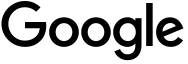

In [87]:
# Prettify the object with the prettify method
print(soup.prettify())

In [175]:
links = soup.find_all('a', href=True)
len(links)

65

In [135]:
import re
links = soup.find_all('a', href=re.compile("https://www.dr.dk/nyheder/+"))

In [ ]:
for i in link_list

True

In [210]:
link_list = link_list[link_list[i] != "webcache.googleusercontent"]

TypeError: list indices must be integers or slices, not Tag

In [228]:
link_list_clean

['https://www.dr.dk/nyheder/penge/danske-sygeplejersker-faar-job-i-norge',
 'https://www.dr.dk/nyheder/regionale/sjaelland/naesten-ingen-ledige-sygeplejersker',
 'https://www.dr.dk/nyheder/indland/dom-i-drabssag-fra-skodborg-i-dag',
 'https://www.dr.dk/nyheder/regionale/nordjylland/socialminister-vi-kommer-til-laere-af-rebild-sagen',
 'https://www.dr.dk/nyheder/regionale/sjaelland/hjaelp-syge-til-finde-vej-i-labyrinten',
 'https://www.dr.dk/nyheder/regionale/trekanten/doede-af-legionaersyge',
 'https://www.dr.dk/nyheder/regionale/sjaelland/regionsformand-jeg-har-ikke-noget-undskylde',
 'https://www.dr.dk/nyheder/regionale/hovedstadsomraadet/v-politiker-demonstranter-er-klynkere',
 'https://www.dr.dk/nyheder/da-lille-rikke-loeb-ind-i-margrethe',
 'https://www.dr.dk/nyheder/penge/langtidsledigheden-er-eksploderet']

In [223]:
link_list_clean = []
for link in range(0, len(link_list)):
    if "webcache.googleusercontent" in link_list[link]:
        link_list_clean.append(link)
del link_list[link_list_clean]

TypeError: list indices must be integers or slices, not list

In [222]:
link_list_clean

[1, 3, 5, 7, 9, 11, 13, 15, 18]

In [215]:
link_list_clean = [link for link in link_list if "webcache.googleusercontent" is not in link_list[link]]

SyntaxError: invalid non-printable character U+00A0 (Temp/ipykernel_9488/3689429311.py, line 1)

In [125]:
links2 = soup.find_all(class_="TbwUpd NJjxre")

In [141]:
links3 = []
for i in links:
    if "TbwUpd NJjxre" in i:
        links3.append()
        else 
            continue
        


SyntaxError: invalid syntax (Temp/ipykernel_9488/3912283193.py, line 5)

## NO CONTENT RETURN

In [ ]:
dr_titles_list = []
dr_date = []
dr_author_list = []
dr_subhead_list = []
dr_content_list = []

for u in tqdm.tqdm(link_list_clean[8:9]):
    re = requests.get(u, headers = {"Name" : "Simon Ullrich - summer course project" , "email": "simon.ullrich@sodas.ku.dk"})
    soup = BeautifulSoup(re.content, "lxml")
    try:
        title = soup.find("div", class_ = "dre-speech")
        dr_titles_list.append(title.text)
    except:
        dr_titles_list.append("")
    try:
        try:
            date = soup.find("time", class_ = "dre-byline__date")['datetime']
            dr_date.append(date)
        except:
            # Different website type: e.g. https://www.dr.dk/nyheder/da-lille-rikke-loeb-ind-i-margrethe
            date = soup.find("div", class_ = "hydra-latest-news-page-short-news__top").find("span", class_ = "dre-label-text__text")
            dr_date.append(pd.to_datetime(date.text))
    except:
        dr_date.append("")
    try:
        author = soup.find("div", class_ = "dre-byline__contribution-details")
        dr_author_list.append(author.text)
    except:
        dr_author_list.append("")
    try:
        subheader = soup.find("p", class_ = "dre-article-title__summary")
        dr_subhead_list.append(subheader.text)
    except:
        dr_subhead_list.append("")
    try:
        try:
            dr_content_i_list = []
            dr_content = soup.find_all("p", class_ = "dre-article-body-paragraph dre-variables")
            for i in dr_content:
                dr_content_i_list.append(i.text)
            dr_content_str = " ".join(dr_content_i_list)
            dr_content_list.append(dr_content_str)
        except:
            dr_content_i_list = []
            dr_content = soup.find("div", class_ = "hydra-latest-news-page-short-news__body")
            for i in dr_content:
                dr_content_i_list.append(i)
                dr_content_str = " ".join(dr_content_i_list)
            dr_content_list.append(dr_content_str)
            
    except:
        dr_content_list.append("")